In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import ast 

In [3]:
data = pd.read_csv(f"s3://project-b-new/LOB_csv/LOB_csv2/2022-02-01-LOB-B02.csv")

In [7]:
data

,Time,Bid,Ask,Date,new_bid
0,0.000,[],[],2022-02-01,0.000000
1,0.017,[],[],2022-02-01,0.000000
2,0.034,[],[],2022-02-01,0.000000
3,0.051,[],[],2022-02-01,0.000000
4,0.068,[],[],2022-02-01,0.000000
...,...,...,...,...,...
1799995,30599.915,"[[168, 5], [161, 2], [129, 3], [107, 4], [106,...","[[262, 4], [278, 1], [294, 5], [386, 2], [429,...",2022-02-01,122.818182
1799996,30599.932,"[[168, 5], [161, 2], [129, 3], [107, 4], [106,...","[[262, 4], [278, 1], [294, 5], [386, 2], [429,...",2022-02-01,122.818182
1799997,30599.949,"[[168, 5], [161, 2], [129, 3], [107, 4], [106,...","[[262, 4], [278, 1], [294, 5], [386, 2], [429,...",2022-02-01,122.818182
1799998,30599.966,"[[168, 5], [161, 2], [129, 3], [107, 4], [106,...","[[262, 4], [278, 1], [294, 5], [386, 2], [429,...",2022-02-01,122.818182


In [4]:
import numpy as np
def new_bid(bid):
    vol = 0
    price = 0
    if type(bid) != float:
        new_bid = ast.literal_eval(bid)
        new_bid = np.array(new_bid)
        if new_bid.size !=0:
            for item in new_bid:
                vol+= item[1]
                price+= item[0]*item[1]
            return price/vol
        else:
            return 0
    else:
        return 0

In [6]:
data['new_bid'] = data.apply(lambda bid: new_bid(bid['Bid']), axis=1)

In [8]:
X = data["Time"]

In [9]:
y = data["new_bid"]

In [16]:
X[0:3].values

array([0.   , 0.017, 0.034])

In [60]:
y.values

array([  0.        ,   0.        ,   0.        , ..., 122.81818182,
       122.81818182, 122.81818182])

In [76]:
y

0            0.000000
1            0.000000
2            0.000000
3            0.000000
4            0.000000
              ...    
1799995    122.818182
1799996    122.818182
1799997    122.818182
1799998    122.818182
1799999    122.818182
Name: new_bid, Length: 1800000, dtype: float64

In [77]:
df = pd.DataFrame(dict(sine=y.values), index=X, columns=['sine'])
print(df)

                 sine
Time                 
0.000        0.000000
0.017        0.000000
0.034        0.000000
0.051        0.000000
0.068        0.000000
...               ...
30599.915  122.818182
30599.932  122.818182
30599.949  122.818182
30599.966  122.818182
30599.983  122.818182

[1800000 rows x 1 columns]


In [78]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

1440000 360000


In [79]:
train

,sine
Time,
0.000,0.000000
0.017,0.000000
0.034,0.000000
0.051,0.000000
0.068,0.000000
...,...
24479.915,112.846154
24479.932,112.846154
24479.949,112.846154


In [111]:
test

,sine
Time,
24480.000,118.162791
24480.017,118.162791
24480.034,118.162791
24480.051,118.162791
24480.068,107.813953
...,...
30599.915,122.818182
30599.932,122.818182
30599.949,122.818182


In [112]:
test.index.to_numpy().shape

(360000,)

In [80]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [81]:
X_train, y_train = create_dataset(train, train.sine, 1)
X_test, y_test = create_dataset(test, test.sine, 1)
print(X_train.shape, y_train.shape)

(1439999, 1, 1) (1439999,)


In [82]:
X_train[:20,:,:]

array([[[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]]])

TypeError: tuple indices must be integers or slices, not tuple

In [83]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc


model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001))

In [85]:
history = model.fit(
    X_train, y_train,
    epochs=1,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

81000/81000 [==============================] - 149s 2ms/step - loss: 45.5107 - val_loss: 36.6007


In [86]:
y_pred = model.predict(X_test)

Text(0.5, 1.0, 'LSTM One Day')

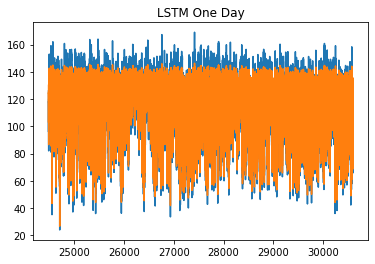

In [113]:
fig, ax = plt.subplots()
ax.plot(test.index.to_numpy()[:-1],y_test)
ax.plot(test.index.to_numpy()[:-1],y_pred)
ax.set_title("LSTM One Day")



In [90]:
print(y_test[:30],y_pred[:30])

[118.1627907  118.1627907  118.1627907  107.81395349 107.81395349
 118.69767442 118.69767442 118.69767442 118.6744186  113.39583333
 113.39583333 113.39583333 113.39583333 113.39583333 113.39583333
 113.39583333 113.39583333 113.39583333 113.08333333 113.08333333
 113.08333333 105.25       100.5625     100.5625     100.5625
 100.5625     100.5625     100.5625     100.5625     100.5625    ] [[124.55333 ]
 [124.55333 ]
 [124.55333 ]
 [124.55333 ]
 [115.384766]
 [115.384766]
 [124.97677 ]
 [124.97677 ]
 [124.97677 ]
 [124.95846 ]
 [120.557915]
 [120.557915]
 [120.557915]
 [120.557915]
 [120.557915]
 [120.557915]
 [120.557915]
 [120.557915]
 [120.557915]
 [120.28218 ]
 [120.28218 ]
 [120.28218 ]
 [112.83971 ]
 [107.939354]
 [107.939354]
 [107.939354]
 [107.939354]
 [107.939354]
 [107.939354]
 [107.939354]]


In [89]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,y_pred)

41.01535547702172

In [36]:
dataset

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.72163829],
       [0.72163829],
       [0.72163829]])

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.66304601],
       [0.66304601],
       [0.66304601]])

array([[0.69428478],
       [0.69428478],
       [0.69428478],
       [0.69428478],
       [0.6334785 ],
       [0.6334785 ],
       [0.69742758],
       [0.69742758],
       [0.69742758],
       [0.69729094],
       [0.66627575],
       [0.66627575],
       [0.66627575],
       [0.66627575],
       [0.66627575],
       [0.66627575],
       [0.66627575],
       [0.66627575],
       [0.66627575],
       [0.6644396 ],
       [0.6644396 ],
       [0.6644396 ],
       [0.61841357],
       [0.5908714 ],
       [0.5908714 ],
       [0.5908714 ],
       [0.5908714 ],
       [0.5908714 ],
       [0.5908714 ],
       [0.5908714 ]])

(1440000, 1) (360000, 1)


array([[0.]])

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15

array([ 4.39959236e-01, -1.37469673e+00,  1.00276692e+00,  4.41546378e-01,
        2.57585288e-01,  4.81345688e-01,  1.12196067e+00,  6.08930278e-01,
        3.57996591e-01,  2.04921747e-02,  6.19407701e-01,  8.23810557e-01,
        8.18841511e-01, -2.44180003e-01,  6.54950531e-02,  5.85488661e-01,
        1.89629089e-01,  3.96361779e-01,  1.31460647e+00,  9.63223519e-01,
        1.80589841e+00,  1.14192026e+00,  5.86753812e-01,  1.71600307e+00,
        5.15776179e-01,  1.03804049e+00,  7.32548600e-01,  5.35135616e-01,
       -1.16957256e-01,  4.73743035e-01,  6.41999653e-01,  9.14711369e-01,
       -2.93469736e-01,  1.27935717e+00, -1.31236503e+00, -1.45017100e+00,
       -9.52225858e-01, -7.30423739e-01, -1.05863712e-01, -6.86642721e-01,
       -8.31796746e-01, -9.90247190e-01,  2.35867573e-01, -6.01757896e-01,
       -1.64238654e+00, -3.65846581e-01, -3.39235344e-01, -6.28475729e-01,
       -7.34341717e-01, -5.97991523e-01, -1.57111710e+00, -6.65091152e-01,
       -8.45651486e-01, -